# Выявление определяющих успешность игры закономерностей

**Задача:**
<br>Проанализировать данные и выявить потенциально популярный продукт


**Описание данных:**

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

**Ход исследования**
Исследование пройдет в 3 этапа:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ.
4. Портрет пользователя каждого региона
5. Проверка гипотез

## Общая информация о данных

### Получение данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy import stats as st
df = pd.read_csv('/datasets/games.csv')

In [2]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Просмотрев данные сделаем следующие выводы и шаги:
* Приведем название столбцов к нижнему регистру
* `Year_of_Release` - поменяем тип данных на int, разберемся с пропусками
* `Name` - посмотрим куда потерялись 2 названия 
* `Critic_Score`/ `User_Score` - почему так много пропусков и чем заменить. `User_score` поменяем тип данных на float
* `Rating` - найдем причину пропусков

## Предобработка данных

### Подготовка данных

#### Приведение к нижнему регистру

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Изменение типов данных

* `year_of_release` на `int`, т.к там прописан только год без лишних данных

In [4]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

* Поменяем тип данных в `user_score`, т.к там не только целые числа
* Перед этим уберем `tbd` т.к аббревиатура значит, что информация не определена, поэтому меняем на NaN

In [5]:
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype(float)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Обработка пропусков

##### Изучим пропуски в столбце `name`

In [6]:
#Пропуски
df['name'].isna().sum()

2

In [7]:
#Процент пропущенных значений
df['name'].isna().mean()

0.00011965300628178283

In [8]:
#Посмотрим на строки с пропусками
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки почти не имеют данных, от них можно просто избавиться, ничего страшного не произойдет, слишком маленький процент пропущенных значений

In [9]:
#Удалим строки
df = df.dropna(subset=['name'])
df['name'].isna().sum()

0

##### Изучим пропуски в столбце `year_of_release`

In [10]:
#Пропуски
df['year_of_release'].isna().sum()

269

In [11]:
#Процент пропущенных значений
df['year_of_release'].isna().mean()

0.016095255190570215

In [12]:
#Посмотрим на строки с пропусками
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Аналогичная ситуация:
* Пропущенные значения составляют 1.6%, что не является существенным, поэтому тоже их удалим

In [13]:
#Удалим строки
df = df.dropna(subset=['year_of_release'])
df['year_of_release'].isna().sum()

0

##### Изучим пропуски в столбцах `critic_score` и `user_score`

In [14]:
#Пропуски в critic_score
df['critic_score'].isna().sum()

8461

In [15]:
#Процент пропущенных значений в critic_score
df['critic_score'].isna().mean()

0.5145341765993675

In [16]:
#Пропуски в user_score
df['user_score'].isna().sum()

8981

In [17]:
#Процент пропущенных значений в user_score
df['user_score'].isna().mean()

0.5461566528825104

Процент пропусков слишком велик, трогать их не будем, т.к это отразиться на выводах.

##### Изучим пропуски в столбце `rating`

In [18]:
#Пропуски в rating
df['rating'].isna().sum()

6676

In [19]:
#Процент пропущенных значений в rating
df['rating'].isna().mean()

0.40598394551204087

40% пропусков, очень много, поставим заглушку в виде tbd, что значит неопределено

In [20]:
df['rating'] = df['rating'].fillna('tbd')

In [21]:
df['rating'].isna().sum()

0

In [22]:
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,tbd
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,tbd
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,tbd


### Суммарные продажи во всех регионах

Создадим столбец с суммарными продажами

In [23]:
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,tbd,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,tbd,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,tbd,0.01


Данные обрабоботаны, пропуски заполнены, типы изменены

## Исследовательский анализ

### Количество игр по годам
Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [24]:
#Сгруппируем к-во релизов по годам
release = df.groupby('year_of_release')['name'].count().reset_index()
release.columns = ['year', 'quan']
release.head()

,year,quan
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


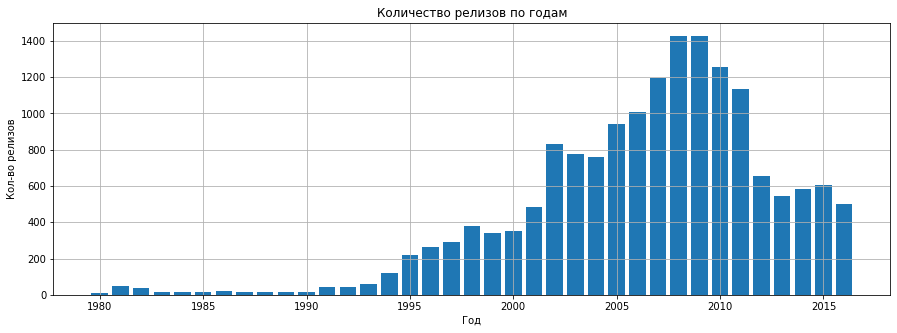

In [25]:
#Построим график
plt.figure(figsize = (15, 5))
plt.bar(release['year'], release['quan'])
plt.grid()
plt.title('Количество релизов по годам')
plt.xlabel('Год')
plt.ylabel('Кол-во релизов');

До 1994 года наблюдается низкая активность по релизам, а потом резкий скачок. Пик приходится на 2008 и 2009 год, а вот в 2012 году график падает вдвое и оставшееся время держится почти на одном уровне.

### Изменение продаж по платформам
Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [26]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,tbd,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd,31.38


In [27]:
#Сгруппируемся по платформам исходя из продаж по всем регионам
platform = (df
            #.query('year_of_release >= 1994')
            .groupby('platform')['all_sales']
            .sum().sort_values(ascending=False)
           )
# Возьемм 5 топ платформ
pltf_top = platform.head().reset_index()
pltf_top
pltf_top_dict = pltf_top['platform'].unique()
pltf_top

,platform,all_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78


Выберем 5 платформ c наибольшими продажами по всем регионам и построим график

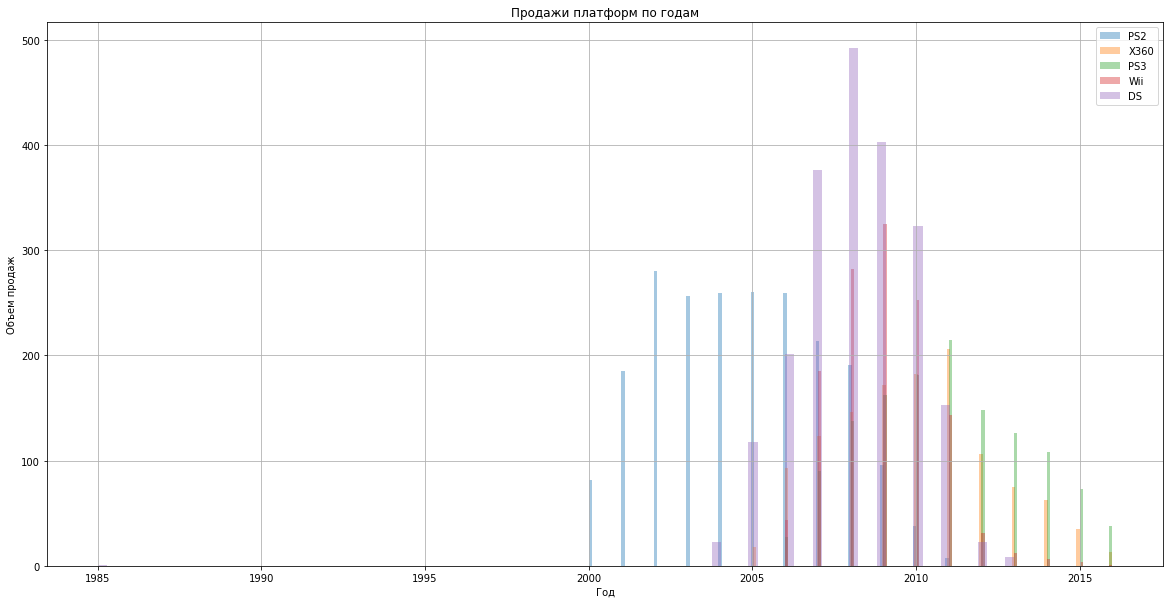

In [28]:
for i in pltf_top_dict:
    (df
        .query('platform == @i')['year_of_release']
        .plot(kind='hist', label=i, grid=True, bins=100, alpha=0.4, legend=True, figsize=(20, 10))
    )
    plt.title('Продажи платформ по годам')
    plt.ylabel('Объем продаж')
    plt.xlabel('Год')
    #plt.show()


По каждому графику нормальное распределение, очень сильно выбивается платформа DS, слишком уж сильно она стрельнула в 2007/2008 году, но также быстро закончилась.
В среднем пик приходится на 5 год существования платформы

<ds> Рассчитаем срок жизни каждой платформы
   

In [29]:
life_time_pl = df.groupby('platform')['year_of_release'].agg(['min', 'max'])
life_time_pl['lifetime'] = (life_time_pl['max'] - life_time_pl['min'])
life_time_pl.sort_values(by = 'lifetime', ascending=False)
#life_time_pl.describe()

,min,max,lifetime
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10
Wii,2006,2016,10


Text(0, 0.5, 'Кол-во релизов')

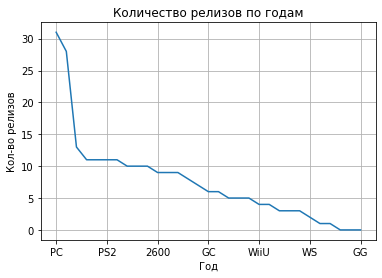

In [30]:
#plt.figure(figsize = (15, 5))
life_time_pl['lifetime'].sort_values(ascending=False).plot()
plt.grid()
plt.title('Количество релизов по годам')
plt.xlabel('Год')
plt.ylabel('Кол-во релизов')

Средний период жизни платформы 7-10 лет, с такой периодичностью они сменяют друг друга.

Можно выделить из списка платформ - "PC" (компьютеры, наверное), они хоть и не в топах по выручке, но актуальны во все времена.
    
<ds>Также надо отметить,что платформа "DS" просуществовала очень длго - до 2013 года.

### Данные за актуальный период
Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Так как с 2009 по - 2016 наблюдается сокращения рынка, возьмем этот период и проанализируем данные исходя из этой тенденции.

Так же в выборку попадут только актуальные платформы на 2016 год

In [31]:
#Создадим таблицу с периодом 2013-2016
df_period = df[df['year_of_release'] >= 2013]
df_period

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,tbd,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,tbd,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01


### Потенциально прибыльные платформы

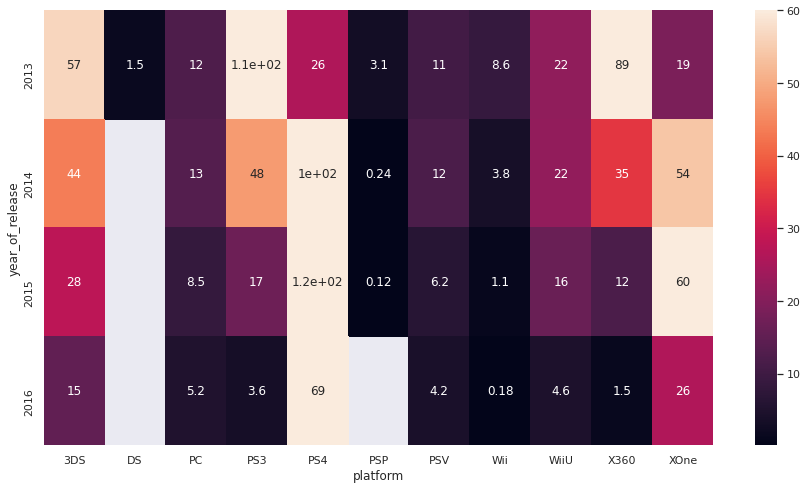

In [32]:
#Тепловая карта по продажам платформ за год
df_pivot = df_period.pivot_table(index = 'platform', columns='year_of_release', values='all_sales', aggfunc='sum').T
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_pivot, vmax=60, annot=True);


Однозначно стоит развивать XOne и PS4, не стоит забывать про 3DS, она приносит больше всего из этого списка после XOne/PS4,
также оставим WiiU, эта консоль немного, но приносит и оставим PC, пусть на нем уже мало кто играет в сравнении с консолями, но все-таки играют.
А в целом видно, что все платформы падают, но PS4 и XOne существуют только 4 года, а исходя из прошлых данных пик приходится на 5 год, так что еще все в переди

In [33]:
#Оставим жизнеспособные платформы
df_period
top_pltf = df_period.query('platform == ["XOne", "PS4", "3DS", "WiiU", "PC"]')
top_pltf

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,tbd,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,tbd,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,tbd,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
...,...,...,...,...,...,...,...,...,...,...,...,...
16660,Prison Architect,XOne,2016,Action,0.01,0.00,0.00,0.00,74.0,6.7,tbd,0.01
16668,Fujiko F. Fujio Characters: Great Assembly! Sl...,3DS,2014,Action,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,tbd,0.01


Итог:
* XOne и PS4 однозначно нужно развивать, у них, конечно, наблюдается спад по продажам, но они даже не дошли до середины своего жизненного цикла, который составляет 10-11 лет
* 3DS тоже стоит рассматривать, эта платформа тоже приносит неплохо денег, больше чем все остальные после XOne/PS4, но не слишком сильно акцентироваться на ней, т.к средний срок жизни подходит к концу, на 2017 хватит
* WiiU и PC тоже можно оставить и осторожно их развивать

### Boxplot по глобальным продажам, в разбивке по платформам
Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [34]:
top_pltf.groupby('platform')['all_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.04,0.09,0.280,14.60
PC,189.0,0.208624,0.352304,0.01,0.03,0.08,0.230,3.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.730,14.63
WiiU,115.0,0.562000,1.038778,0.01,0.06,0.20,0.595,7.09
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.685,7.39


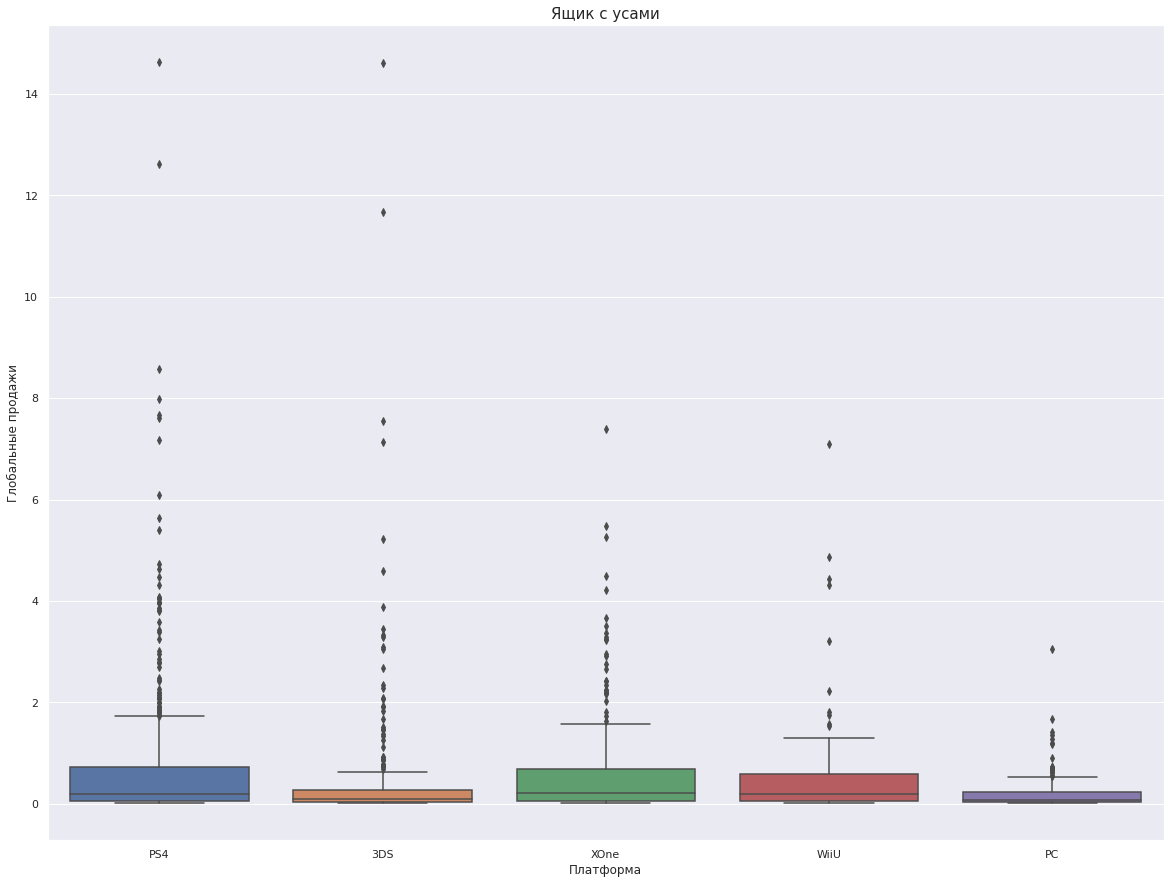

In [35]:
plt.figure(figsize=(20,15))

sns.boxplot(data=top_pltf, x='platform', y='all_sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12);

In [36]:
top_pltf.groupby(['name', 'platform'])['all_sales'].sum().sort_values(ascending=False).head(15)

name                                       platform
Call of Duty: Black Ops 3                  PS4         14.63
Pokemon X/Pokemon Y                        3DS         14.60
Grand Theft Auto V                         PS4         12.62
Pokemon Omega Ruby/Pokemon Alpha Sapphire  3DS         11.68
FIFA 16                                    PS4          8.58
Star Wars Battlefront (2015)               PS4          7.98
Call of Duty: Advanced Warfare             PS4          7.66
FIFA 17                                    PS4          7.60
Super Smash Bros. for Wii U and 3DS        3DS          7.55
Call of Duty: Black Ops 3                  XOne         7.39
Fallout 4                                  PS4          7.17
Pokemon Sun/Moon                           3DS          7.14
Mario Kart 8                               WiiU         7.09
FIFA 15                                    PS4          6.08
Destiny                                    PS4          5.64
Name: all_sales, dtype: float64

In [37]:
top_pltf.groupby('platform')['all_sales'].describe()
top_pltf.groupby('platform')['all_sales'].sum()

platform
3DS     143.25
PC       39.43
PS4     314.14
WiiU     64.63
XOne    159.32
Name: all_sales, dtype: float64

Остается тройка победителей PS4, WiiU и XOne, медианные значения у них практически одинаковые, а вот средние сильно отличаются, это связано с бестселлерами/эксклюзивов, которые кажутся выбросами

### Влияние отзывов на продажи внутри 1 платформы
Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [38]:
#Возьмем самую популярную платформу PS4 и сделаем таблицу только с ней
ps4_df = df[df['platform'] == 'PS4']
ps4_df
#Корреляция между оценками пользователей и продажами
ps4_df['user_score'].corr(ps4_df['all_sales'])

-0.031957110204556376

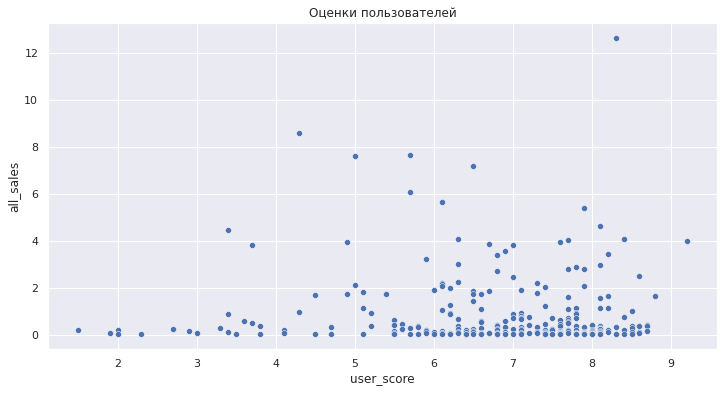

In [39]:
#Построим диагрымму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='all_sales', data=ps4_df)
plt.title('Оценки пользователей');

* Корреляции отсутствует, на покупателей не влияют отзывы пользователей.

In [40]:
#Корреляция между оценками пользователей и продажами
ps4_df['critic_score'].corr(ps4_df['all_sales'])

0.40656790206178095

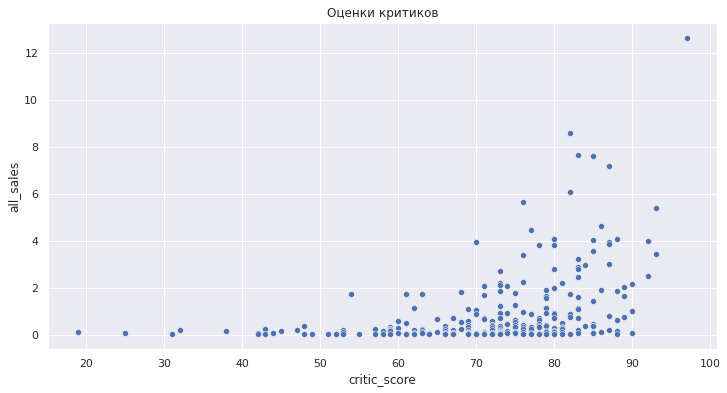

In [41]:
#Построим диагрымму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='all_sales', data=ps4_df)
plt.title('Оценки критиков');

* А вот отзывы критиков немного, но влияют на выбор игры, но все равно не очень сильно

### Продажи игр на других платформах

Возьмем ранее отобранные платформы и посмотрим как у них обстоят дела

In [42]:
df[df['platform'] == 'PS4']['critic_score'].corr(df[df['platform'] == 'PS4']['all_sales'])

0.40656790206178095

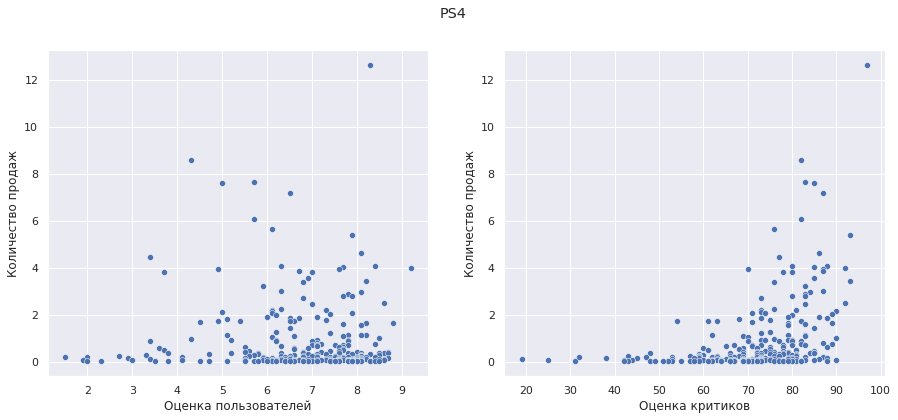

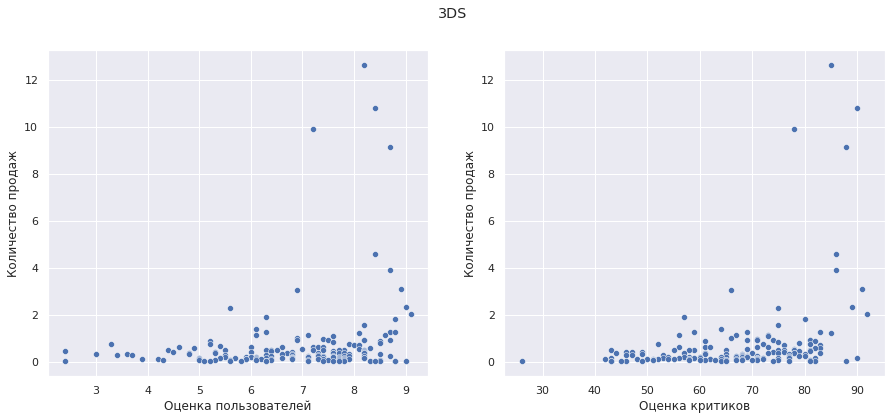

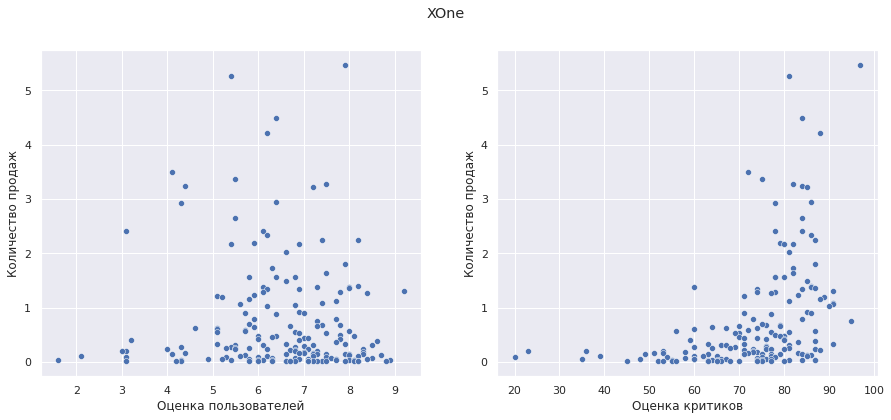

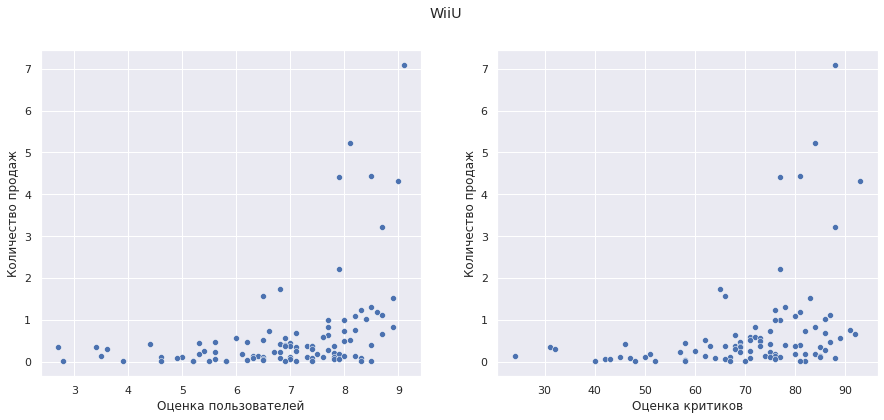

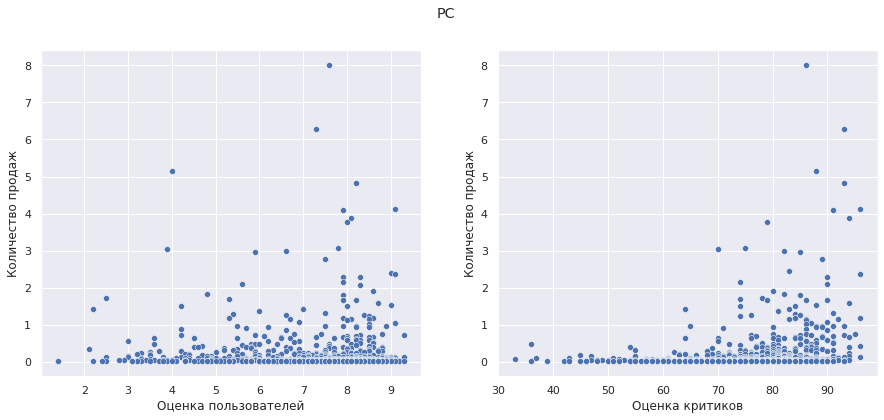

In [43]:
top_dict = top_pltf['platform'].unique()
for i in top_dict:
    f, ax = plt.subplots(1 ,2, figsize=(15,6))
    sns.scatterplot(x='user_score', y='all_sales', data=df[df['platform'] == i], ax=ax[0])
    sns.scatterplot(x='critic_score', y='all_sales', data=df[df['platform'] == i], ax=ax[1])
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.suptitle(i) 

In [44]:
# Корреляция
for i in top_dict:
    print('Корреляция c оценкой критиков ' + i+':',
          df[df['platform'] == i]['critic_score'].corr(df[df['platform'] == i]['all_sales']))
    print('Корреляция c оценкой пользователей ' + i+':',
          df[df['platform'] == i]['user_score'].corr(df[df['platform'] == i]['all_sales']))
    print()

Корреляция c оценкой критиков PS4: 0.40656790206178095
Корреляция c оценкой пользователей PS4: -0.031957110204556376

Корреляция c оценкой критиков 3DS: 0.3487397305984834
Корреляция c оценкой пользователей 3DS: 0.22207843643390882

Корреляция c оценкой критиков XOne: 0.4169983280084017
Корреляция c оценкой пользователей XOne: -0.06892505328279414

Корреляция c оценкой критиков WiiU: 0.34837976012017485
Корреляция c оценкой пользователей WiiU: 0.4002190202148617

Корреляция c оценкой критиков PC: 0.257394718400985
Корреляция c оценкой пользователей PC: 0.012904741611451175



По остальным примерно такая же ситуация:
* Оценки критиков совсем не сильно влияют на выбор
* Оценки пользователей почти не влияют на выбор
* Исключением стала платформа Wiiu, тут и критики и пользователи в равной степени влияют на выбор

Оценки критиков все-таки больше вляют на выбор клиента

### Распределение игр по жанрам

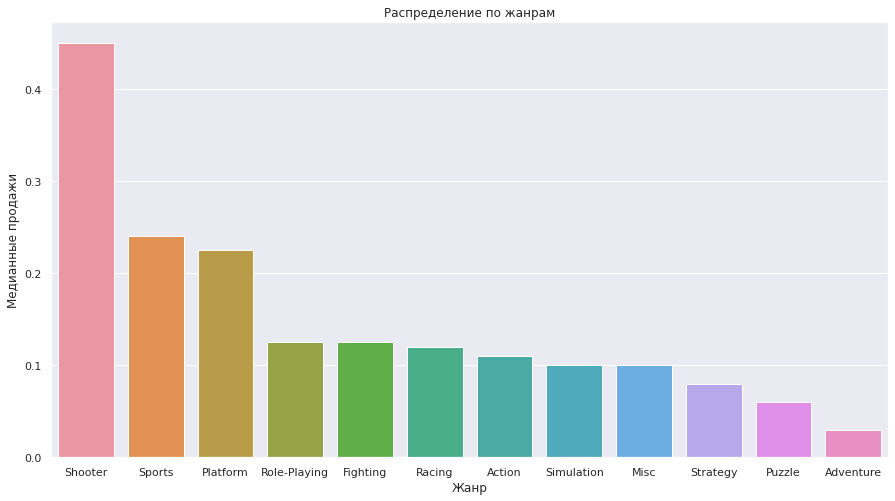

In [45]:
genre_sales = df_period.groupby('genre')['all_sales'].describe().reset_index().sort_values('50%', ascending=False)
genre_sales.groupby('genre')['50%'].sum().sort_values(ascending=False)
plt.title('Распределение по жанрам')
sns.barplot(x='genre', y='50%', data=genre_sales)
plt.xlabel('Жанр')
plt.ylabel('Медианные продажи');

* Наиболее прибыльными жанрами являются `Shooter`, `Sports`, `Platform`, среди которых шутеры являются самимыми прибыльными
* Самыми неприбыльными жанром является `Adventure`
* Остальные приблизительно равны

In [46]:
genre_sales = df_period.groupby('genre')['all_sales'].sum().reset_index()

#genre_sales.as

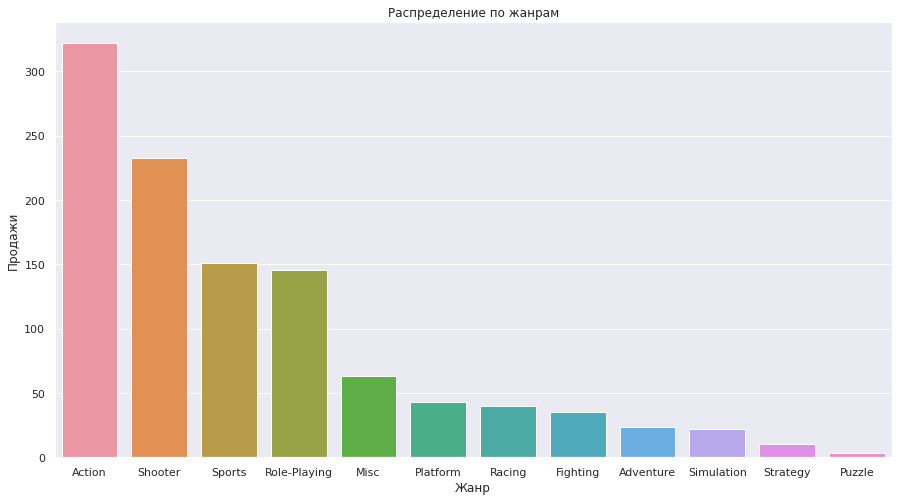

In [47]:
genre_sales = df_period.groupby('genre')['all_sales'].sum().reset_index().sort_values('all_sales', ascending=False)
plt.title('Распределение по жанрам')
sns.barplot(x='genre', y='all_sales', data=genre_sales)
plt.xlabel('Жанр')
plt.ylabel('Продажи');

* Сильнее всего, по к-ву, продаж выделятся `Action` and `Shooter`, это связано с массовостью жанра
* Хуже всего продатся `Puzzle`, не очень любят на приставке пазлы решать

### Вывод по исследовательскому анализу

* Количество игр на игровые приставки и компьютеры начало расти с большой скоростью с 93 года до 2009 года. С 2008 года, после того как массово начали создавать мобильные приложения и мобильные игры, произошел резкий спад разработок игр на игровые платформы.
* Самые популярные игровые платформы за весь период : Sony PlayStation 2, Xbox 360, Sony Playstation 3, Nintendo WII, Nintendo DS.
* Средняя жизнь игровой платформы составляет 10 лет. Пик продаж наступает примерно через 5 лет после выхода приставки.
* Nintendo WII как быстро появился также быстро и потух. Возможно потому что появился прям перед выходом мобильных приложений и игр.
* У всех платформ наблюдается взаимосвязь между продажами и оценками критиков и пользователей. Заметнее всего корреляция между оценками критиков и продажами. Это значит для людей мнение критиков важнее мнения других пользователей

## Портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Напишем функцию, которая будет строит сводные таблицы и чертить графики по требуемому региону

In [48]:
df_dict = ['platform', 'genre', 'rating']
def pivot_plot(row, title):
    f, ax = plt.subplots(1 ,3, figsize=(20, 6))
    for i in df_dict:
        pivot = (df_period.pivot_table(index=i, values = row, aggfunc='sum')
                   .sort_values(by = row, ascending=False)
                .reset_index())
        pivot['ratio'] = pivot[row] / pivot[row].sum()
        display(pivot)
        sns.barplot(x=i, y=row, data=pivot, ax=ax[df_dict.index(i)])
        ax[df_dict.index(i)].tick_params(axis='x', rotation=90)
        f.suptitle(title, fontsize=25)

### Портрет пользователя региона NA

,platform,na_sales,ratio
0,PS4,108.74,0.248429
1,XOne,93.12,0.212744
2,X360,81.66,0.186562
3,PS3,63.50,0.145073
4,3DS,38.20,0.087272
5,WiiU,29.21,0.066734
6,PC,11.11,0.025382
7,Wii,6.56,0.014987
8,PSV,5.04,0.011514
9,DS,0.57,0.001302


,genre,na_sales,ratio
0,Action,126.05,0.287976
1,Shooter,109.74,0.250714
2,Sports,65.27,0.149117
3,Role-Playing,46.40,0.106006
4,Misc,27.49,0.062804
5,Platform,18.14,0.041443
6,Fighting,15.55,0.035526
7,Racing,12.96,0.029609
8,Adventure,7.14,0.016312
9,Simulation,4.86,0.011103


,rating,na_sales,ratio
0,M,165.21,0.377442
1,tbd,89.42,0.204291
2,E,79.05,0.180599
3,E10+,54.24,0.123918
4,T,49.79,0.113751


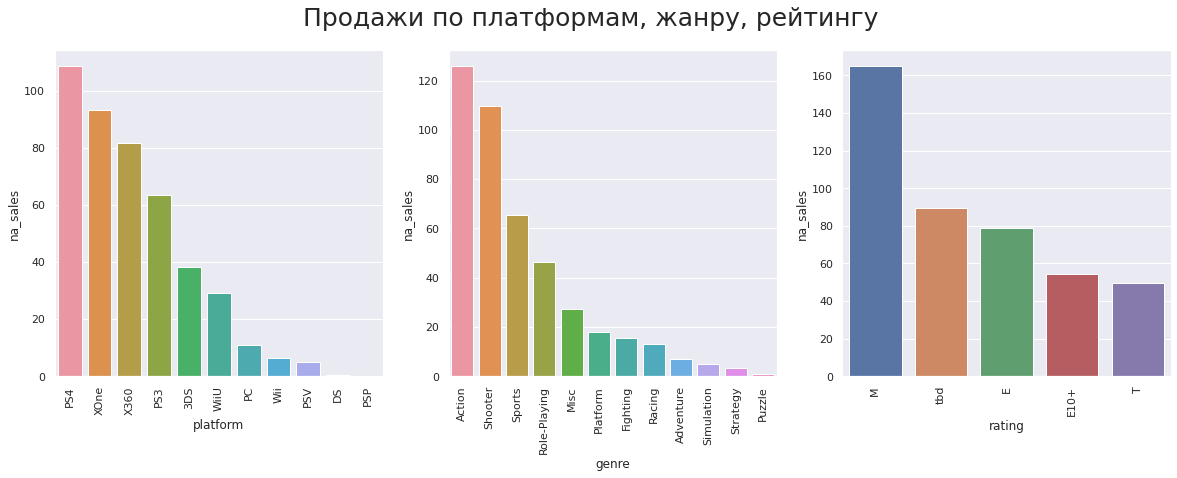

In [49]:
pivot_plot('na_sales', 'Продажи по платформам, жанру, рейтингу ')

**Популярными платформами в NA являются X360, PS3, Wii, DS, PS4 с долями 28%, 20%, 16%, 8% и 7% соответственно.**
* Самыми популярные платформы это X360, PS3 которые занимают почти 50% рынка, следом идет Wii и новые поколения XBox и PS.
* Т.к XOne and PS4 еще даже не дошли своего пика, можно смело предположить что со временем они станут первыми.
* Также в этом регионе лидирует X360, поэтому можно предположить, что XOne станет лидером

**Популярными жанрами в NA являются Action, Shooter, Sports, Misc, Role_Playing с долями 24%, 19%, 15%, 11% и 9% соответственно.** 

**В Северной Америке отдают предпочтение играм категории М (от 17) и Е(для всех), доля продаж которых составляет 57% по всему региону. Свазяно это наверное с тем, что в совсем детские игры неинтересно играть**

### Портрет пользователя региона  EU

,platform,eu_sales,ratio
0,PS4,141.09,0.359712
1,PS3,67.81,0.172883
2,XOne,51.59,0.131530
3,X360,42.52,0.108406
4,3DS,30.96,0.078933
5,PC,25.36,0.064656
6,WiiU,19.85,0.050608
7,PSV,6.10,0.015552
8,Wii,5.93,0.015119
9,DS,0.85,0.002167


,genre,eu_sales,ratio
0,Action,118.13,0.301175
1,Shooter,87.86,0.224001
2,Sports,60.52,0.154297
3,Role-Playing,36.97,0.094256
4,Racing,20.19,0.051475
5,Misc,20.04,0.051092
6,Platform,15.58,0.039722
7,Simulation,10.92,0.027841
8,Fighting,8.55,0.021798
9,Adventure,8.25,0.021034


,rating,eu_sales,ratio
0,M,145.32,0.370497
1,E,83.36,0.212528
2,tbd,78.91,0.201183
3,E10+,42.69,0.108839
4,T,41.95,0.106953


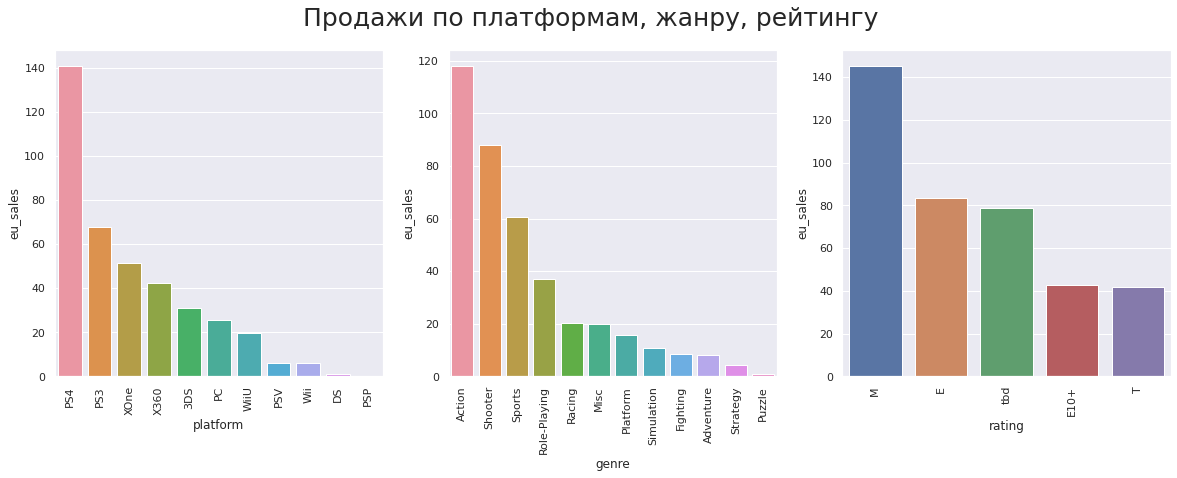

In [50]:
pivot_plot('eu_sales', 'Продажи по платформам, жанру, рейтингу ')

**Популярными платформами в EU являются PS3, X360, PS4, Wii, PC,  с долями 25%, 19%, 14%, 12% и 8% соответственно.**
* В этом регионе также популярны платформы PS, X360 и Wii, только в топ 5 тут добавился PC
* В Европе очень любят платформы PS, они занимают 1 и 3 место в общем рейтинге, а вот XBox немного меньше

**Популярными жанрами в NA являются Action, Shooter, Sports, Misc, Role_Playing с долями 26%, 19%, 15%, 8% и 8% соответственно.**
* Сутация такая же как и с Северной Америкой

**В Европе отдают предпочтение играм категории М (от 17) и Е(для всех), доля продаж которых составляет 56% по всему региону. Свазяно это наверное с тем, что в совсем детские игры неинтересно играть**

### Портрет пользователя региона  JP

,platform,jp_sales,ratio
0,3DS,67.81,0.481674
1,PS3,23.35,0.165862
2,PSV,18.59,0.132050
3,PS4,15.96,0.113368
4,WiiU,10.88,0.077284
5,PSP,3.29,0.023370
6,X360,0.51,0.003623
7,XOne,0.34,0.002415
8,Wii,0.05,0.000355
9,DS,0.00,0.000000


,genre,jp_sales,ratio
0,Role-Playing,51.04,0.362551
1,Action,40.49,0.287612
2,Misc,9.20,0.065350
3,Fighting,7.65,0.054340
4,Shooter,6.61,0.046953
5,Adventure,5.82,0.041341
6,Sports,5.41,0.038429
7,Platform,4.79,0.034025
8,Simulation,4.52,0.032107
9,Racing,2.30,0.016338


,rating,jp_sales,ratio
0,tbd,85.05,0.604134
1,T,20.59,0.146257
2,E,15.14,0.107544
3,M,14.11,0.100227
4,E10+,5.89,0.041838


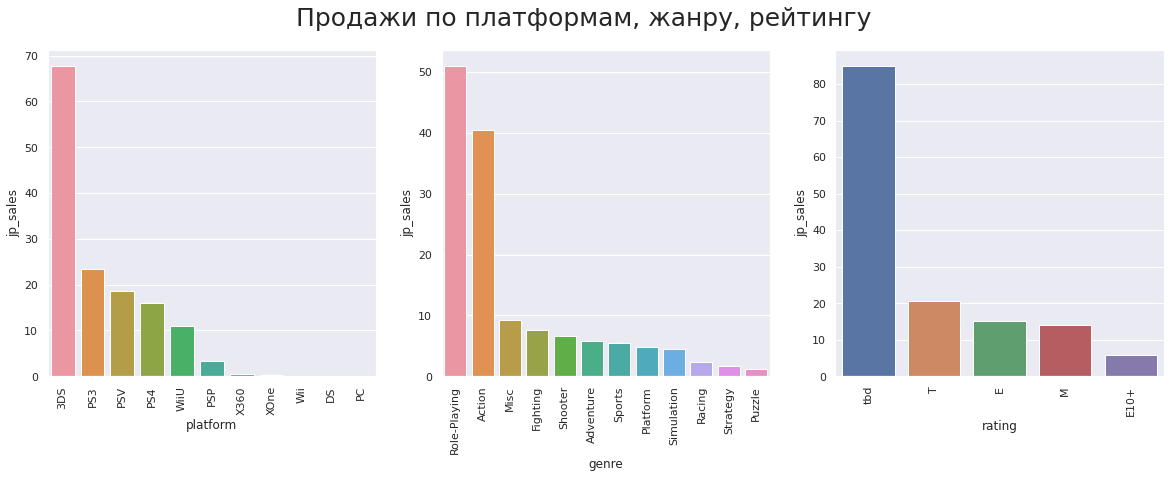

In [51]:
pivot_plot('jp_sales', 'Продажи по платформам, жанру, рейтингу ')

**Популярными платформами в EU являются 3DS, PS3, DS, PSP, Wii,  с долями 27%, 18%, 14%, 13% и 9% соответственно.**
* В Японии совсем другая ситуация, в этом регионе предпочтение отдают "карманным" платформам, но также не забывают про PS, сонька там тоже популярна, а вот популярная в других региона XBox не пользуется популярностью в Японии
* В Европе очень любят платформы DS, они занимают 1 и 3 место в общем рейтинге

**Популярными жанрами в NA являются Role-Playing, Action, Misc, Sports, Platform с долями 33%, 23%, 8%, 7% и 5% соответственно.**
* В Японии очень любят ролевые Role_playing and Action

**В Японии рейтинг не влияет на продажи игр, да и у 54% игр он не определён**

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Проверка гипотез начинается с формулировки нулевой гипотезы H0:
* H0  — cредние пользовательские рейтинги платформ Xbox One и PC различаются.

Отвергнув/подтвердив ее мы ответим на требуемый вопрос

Исходя из H0 формулируется альтернативная гипотеза H1. Это утверждение, которое принимается верным, если отбрасывается H0:
* H1 — cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Имеем две генеральные совокупности cредние пользовательские рейтинги платформ `XOne` и `PC`, поэтому будем сравнивать средние двух генеральных совокупностей между собой методом scipy.stats.ttest_ind()

Пороговое значение:
* alpha = 1%

In [52]:
#Средние рейтинги по платформам за актуальный период
ur_xone = df_period[df_period['platform'] == 'XOne']['user_score']
ur_pc = df_period[df_period['platform'] == 'PC']['user_score']
#Проверим дисперсии выборок чтобы корректно определить атрибут equal_val в Т–тесте.
print(ur_xone.var())
print(ur_pc.var())

1.9069968429360695
3.035892752408881


In [53]:
ur_xone

99       NaN
165      7.9
179      5.4
242      6.4
270      6.2
        ... 
16630    8.2
16643    6.6
16645    NaN
16660    6.7
16672    NaN
Name: user_score, Length: 247, dtype: float64

Дисперсии разные, атрибут `equal_val = False`

In [54]:
alpha = .01

results = st.ttest_ind(
    ur_xone.dropna(), 
    ur_pc.dropna(), 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


In [55]:
print(ur_xone.mean())
print(ur_pc.mean())

6.521428571428572
6.269677419354839


Значение p-value равно чуть меньше 3%. Таким образом, не получилось опровергнуть Нулевую гипотезу. То есть, с вероятностью в 3% можно получить различность рейтингов двух платформ

### Средние пользовательские рейтинги жанров Action  и Sports разные.

Проверка гипотез начинается с формулировки нулевой гипотезы H0:
* H0  — cредние пользовательские рейтинги платформ Action и Sports одинаковые.

Отвергнув/подтвердив ее мы ответим на требуемый вопрос

Исходя из H0 формулируется альтернативная гипотеза H1. Это утверждение, которое принимается верным, если отбрасывается H0:
* H1 — cредние пользовательские рейтинги платформ Action и Sports разные.

Имеем две генеральные совокупности cредние пользовательские рейтинги жанров `Action` и `Sports`, поэтому будем сравнивать средние двух генеральных совокупностей между собой методом scipy.stats.ttest_ind()

Пороговое значение:
* alpha = 1%

In [56]:
#Средние рейтинги по жанрам за актуальный период
ur_action = df_period[df_period['genre'] == 'Action']['user_score']
ur_sports = df_period[df_period['genre'] == 'Sports']['user_score']
#Проверим дисперсии выборок чтобы корректно определить атрибут equal_val в Т–тесте.
print(ur_xone.var())
print(ur_pc.var())

1.9069968429360695
3.035892752408881


Дисперсии разные, атрибут `equal_val = False`

In [57]:
alpha = .01

results = st.ttest_ind(
    ur_action.dropna(), 
    ur_sports.dropna(), 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


 Получив p-value, мы отвергли Нулевую гипотезу. Таким образом, у нас практически нет вероятности получить одинакове средние рейнтинги по двум жанрам.

### Вывод
Проверили гипотезы по ТЗ:

- Гипотеза: "Средние пользовательские рейтинги платформ Xbox one и PC одинаковые". Отвергаем гипотезу.
- Гипотеза: "Средние пользовательские рейтинги жанров Action и Sports разные". Подтверждаем гипотезу.

## Вывод

* Перед анализом данных, мы подготовили наши данные, привели к правильным данным столбцы, привели к нижнему регистру таблицы и сами названия колонок и Привели к правильным типам данных необходимые столбцы.
* Проведя анализ, мы выявили, что количество игр на игровые приставки и компьютеры начало расти с большой скоростью с 90х до 2008 года. С 2008 года после того как массово начали создавать мобильные приложения и мобильные игры, произошел резкий спад разработок консольных игр
* За весь период консольных приставок самые популярные оказались: PS2, X360, PS3, WII, DS, PS
* Также мы выявили, что средняя продолжительность жизни игровой приставки составляет 7-10 лет. Самый пик продаж наступает примерно через 5 лет после выпуска консоли
* Мы выявили, что оценки критиков совсем не сильно влияют на выбор, а оценки пользователей почти не влияют на выбор. Исключением стала платформа Wiiu, тут и критики и пользователи в равной степени влияют на выбор
* Так же определили, что самый популярный жанр за все время это Экшн. На последнем месте стратегии
* После мы составили портреты пользователей каждого региона.

* Выяснили, что в Северной америке самые популярные жанры это Action, Sports, Shooter. Игровые приставки : X360, PS3 и WII. А по рейтингу игр люди предпочитают игры с рейтингами: "для всех", "от 13 и выше" и "от 17 и выше".
* В Европе же, популярные жанры точно такие же как и в Северной Америке. Но приставки предпочитают по следующей очередности: PS3, X360, PS4. В Европе очень любят PS. Рейтинг такой-же как и в NA
* В Японии люди предпочитают игровые приставки: 3DS, PS3 и DS. А жанры игры : Role-playing, Action и Sports. Рейтинг игр слабо распространен в Японии.

Исходя из всех данных предполагаем, что лучше всего продавать игры для таких приставок как Sony Playstation 4 и XOne, но и не стоит забывать про WiiU

Жанр необходимо выбирать Shooter/Action и выбирать игры с рейтингом "от 17 и выше", тогда продажи будут значительно больше, чем если продавать другие игры.